In [1]:
# TODO: MUST check this error later
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(0)

In [3]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

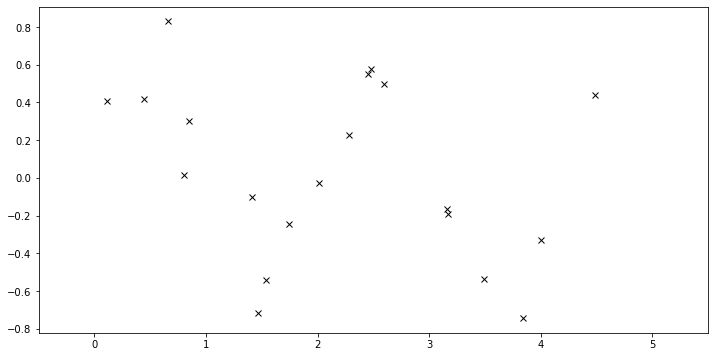

In [4]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

In [5]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

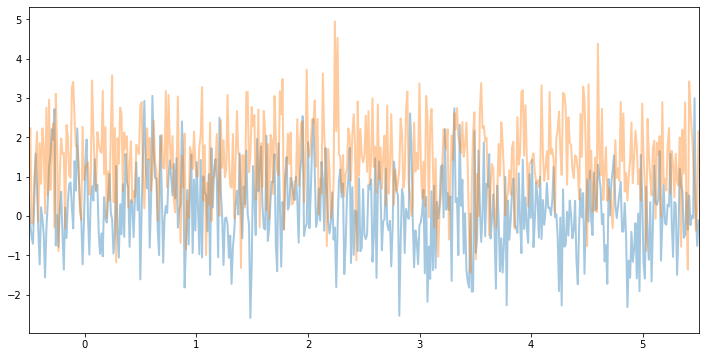

In [6]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)


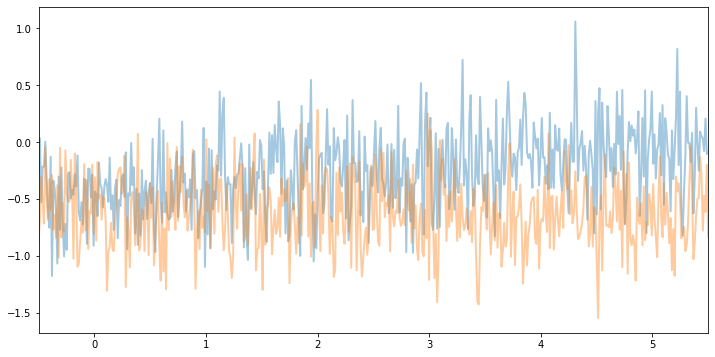

In [7]:
kernel2 = gp.kernels.RBF(input_dim=1, variance=torch.tensor(0.1),
                         lengthscale=torch.tensor(10.))
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.1))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)

In [8]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

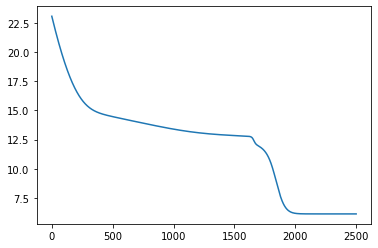

In [9]:
# let's plot the loss curve after 2500 steps of training
plt.plot(losses);


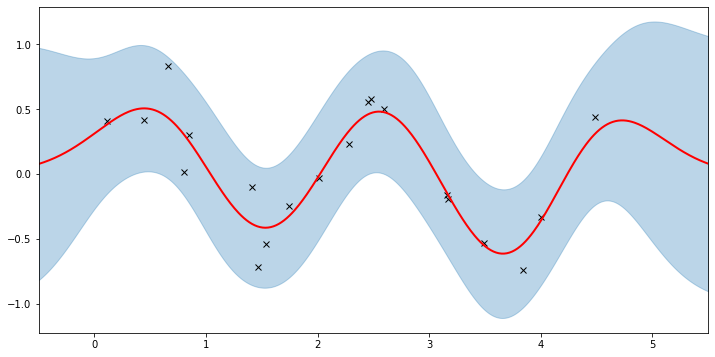

In [10]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)


In [11]:
gpr.kernel.variance.item(), gpr.kernel.lengthscale.item(), gpr.noise.item()


(0.2029135525226593, 0.5022152066230774, 0.04272934049367905)

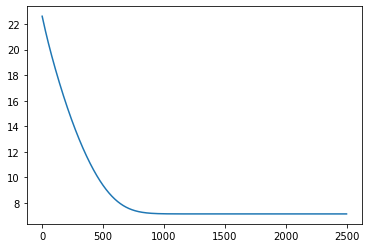

In [12]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance    = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses);

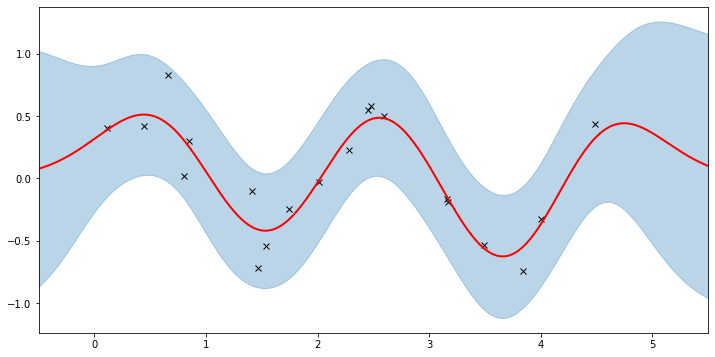

In [13]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)


In [14]:
# tell gpr that we want to get samples from guides
gpr.set_mode('guide')
print('variance = {}'.format(gpr.kernel.variance))
print('lengthscale = {}'.format(gpr.kernel.lengthscale))
print('noise = {}'.format(gpr.noise))

variance = 0.2447141408920288
lengthscale = 0.5217678546905518
noise = 0.04222293198108673


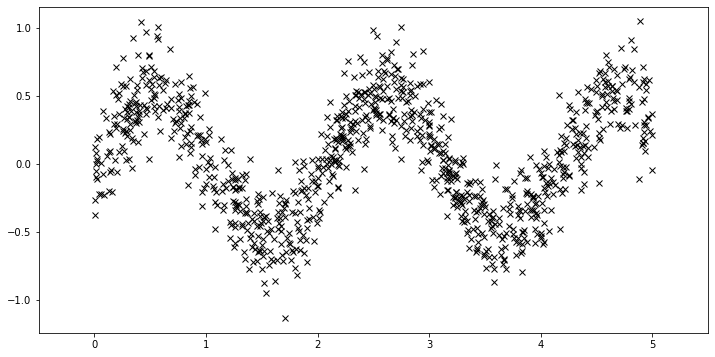

In [15]:
#### More data
N = 1000
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))
plot(plot_observed_data=True)

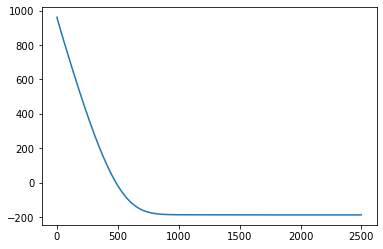

In [16]:
# initialize the inducing inputs
Xu = torch.arange(20.) / 4.0

# initialize the kernel and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
# we increase the jitter for better numerical stability
sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-5)

# the way we setup inference is similar to above
optimizer = torch.optim.Adam(sgpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(sgpr.model, sgpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses);


inducing points:
[0.03889933 0.25772077 0.50514966 0.75845516 0.99672544 1.2941477
 1.5096065  1.7683834  2.052939   2.2531183  2.5101745  2.7806995
 3.049132   3.5910516  3.3180087  3.898384   4.197492   4.485304
 4.7663984  4.975934  ]


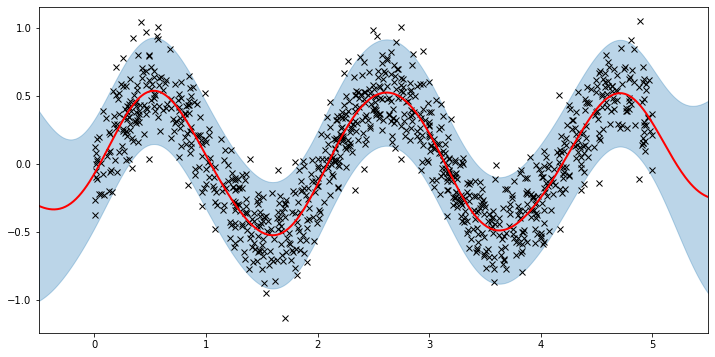

In [17]:
# let's look at the inducing points we've learned
print("inducing points:\n{}".format(sgpr.Xu.data.numpy()))
# and plot the predictions from the sparse GP
plot(model=sgpr, plot_observed_data=True, plot_predictions=True)

# Rt Gaussian Process


\begin{equation}
    \begin{split}
    R_t \sim & R_{t-q}\times GP\\
    I_t = &R_t \sum_\tau w_\tau I_{t-\tau} \quad \text{(Convolve with generation interval) - Same as EpiEstim}\\
    D_t = & \sum_\tau \zeta_\tau I_{t-\tau} \quad \text{(Convolve since infection to report symptom onset and report ddelay)}\\
    C_t \sim & NB(D_t \omega_{t7} , \phi)
    \end{split}
\end{equation}


In [87]:
import sys

sys.path.insert(0, '..')

from functions.adjust_cases_functions import prepare_cases 
from functions.general_utils import  get_bool
from models.seird_model import SEIRD

from statsmodels.tsa.arima.model import ARIMA


import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

from global_config import config


poly_run  = 11001
name_dir  = 'bogota'
drop_last_weeks = False

data_dir            = config.get_property('data_dir_covid')
geo_dir             = config.get_property('geo_dir')
data_dir_mnps       = config.get_property('data_dir_col')
results_dir         = config.get_property('results_dir')

agglomerated_folder = os.path.join(data_dir, 'data_stages', 'colombia', 'agglomerated', 'geometry' )
raw_folder          = os.path.join(data_dir, 'data_stages', 'colombia', 'raw', 'cases' )

polygons = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')
polygons = polygons.loc[poly_run]


data_raw  =  pd.read_csv(os.path.join(raw_folder, 'cases_raw.csv'), dayfirst=True)

data  =  pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates=['date_time'], dayfirst=True).set_index('poly_id')
data  = data.loc[poly_run].set_index('date_time')
data  = data.resample('D').sum().fillna(0)[['num_cases','num_diseased']]
data  = prepare_cases(data, col='num_cases', cutoff=0)   
data  = prepare_cases(data, col='num_diseased', cutoff=0)


/Users/chaosdonkey06/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


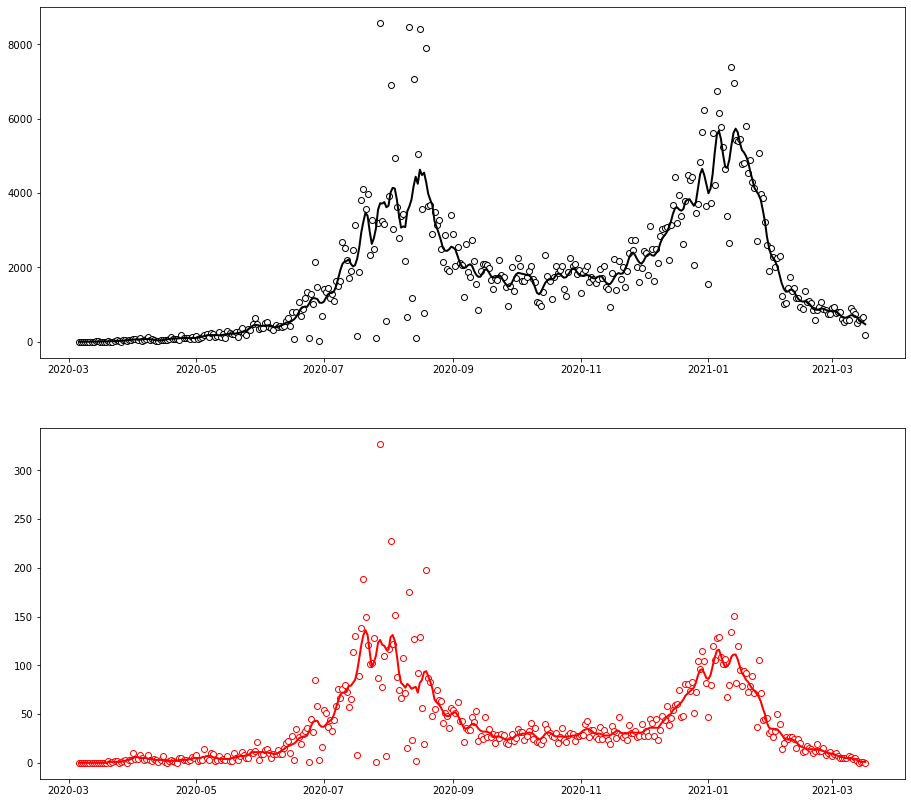

In [89]:
fig, ax = plt.subplots(2, 1, figsize=(15.5, 14.2))

ax[0].plot(data.index.values, data.smoothed_num_cases, color='k', linewidth=2)
ax[0].scatter(data.index.values, data.num_cases, edgecolor='k', facecolor='w')

ax[1].plot(data.index.values, data.smoothed_num_diseased, color='r', linewidth=2)
ax[1].scatter(data.index.values, data.num_diseased, edgecolor='r', facecolor='w')



/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Generation Time ~ Gamma')

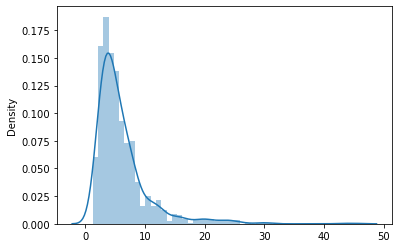

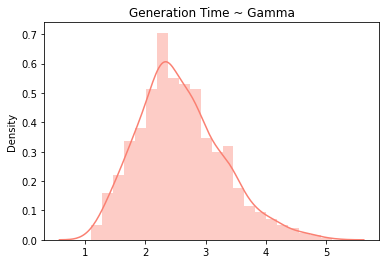

In [103]:
import seaborn as sns


a = dist.InverseGamma(concentration=3.5, rate=15)
x = a.rsample(sample_shape=torch.Size([1000])) # draw a sample from N(0,1)

sns.distplot(x, label="Gamma")



plt.figure()
mu    = 3.6
sigma = 0.7
# Shift -1
a = ((mu - 1) / sigma)**2  # shape
b = sigma**2 / (mu - 1)    # scale

# here concentration = shape, rate=1/scale
gen_time = dist.Gamma(concentration=a , rate=1/b )

x = gen_time.rsample(sample_shape=torch.Size([1000])) # draw a sample from N(0,1)
sns.distplot(x, label="Gamma", color='salmon')
plt.title('Generation Time ~ Gamma')

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Incubation period ~ LogNormal')

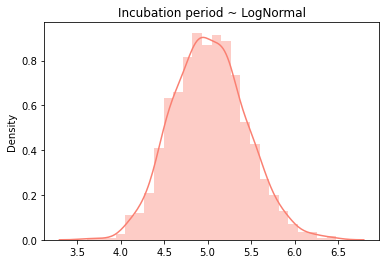

In [116]:


mean = 5.2
sd   = 1.52
loc   = np.log( mean**2 / np.sqrt(mean**2 + sd**2) )
scale = np.log( 1 + sd**2 / mean**2 )
incubation_period = dist.LogNormal(loc, scale)

x = incubation_period.rsample(sample_shape=torch.Size([1000])) # draw a sample from N(0,1)
sns.distplot(x, label="Gamma", color='salmon')
plt.title('Incubation period ~ LogNormal')



\begin{equation}
    \begin{split}
    R_t \sim & R_{t-1}\times GP\\
    I_t = &R_t \sum_\tau w_\tau I_{t-\tau} \quad \text{(Convolve with generation interval) - Same as EpiEstim}\\
    D_t = & \sum_\tau \zeta_\tau I_{t-\tau} \quad \text{(Convolve since infection to report symptom onset and report ddelay)}\\
    C_t \sim & NB(D_t \omega_{t7} , \phi)
    \end{split}
\end{equation}


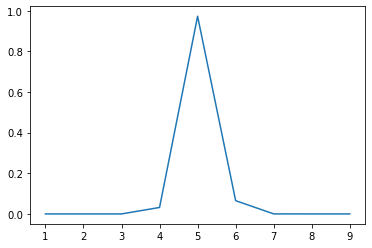

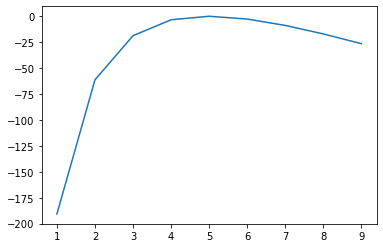

In [139]:
######################## Generation Time ################
# This resulted in a distributed generation time with mean 3.6 days (standard deviation (SD) 0.7)
#  and SD of 3.1 days (SD 0.8) for all estimates.
mu    = 3.6
sigma = 0.7
# Shift -1
a = ((mu - 1) / sigma)**2  # shape
b = sigma**2 / (mu - 1)    # scale

# here concentration = shape, rate=1/scale
generation_time   = dist.Gamma(concentration=a , rate=1/b )
########################################################


######################## Incubation Period ################
# log-normal incubation period with a mean of 5.2 days (SD 1.1) and SD of 1.52 days (SD 1.1)
mean = 5.2
sd   = 1.52
loc   = np.log( mean**2 / np.sqrt(mean**2 + sd**2) )
scale = np.log( 1 + sd**2 / mean**2 )
incubation_period = dist.LogNormal(loc, scale)
########################################################


x_eval = torch.Tensor(list(range(1,10)))
a      = torch.exp( incubation_period.log_prob( x_eval ) )

plt.plot(x_eval, a)

plt.figure()
plt.plot(x_eval, incubation_period.log_prob( x_eval ) )

In [79]:
from pyro.infer import MCMC, NUTS

# Define the same model as before.
pyro.clear_param_store()

################################################################
#                                                              #
#                         KERNEL                               #
#                                                              #
################################################################

# KernelPriors
kernel = gp.kernels.RBF(input_dim=1) # input dim is time )
# note that our priors have support on the positive reals
kernel.variance    = pyro.nn.PyroSample(dist.Normal(0.0, 1.0))               # The prior on the magnitude was standard normal.
kernel.lengthscale = pyro.nn.PyroSample(dist.InverseGamma(concentration=3.5, rate=15)) # Inverse gamma prior with shape and scale values optimised to give a distribution with 98% of the density between 2 days and 21 days. 




################################################################
#                                                              #
#                         EpiEstim                               #
#                                                              #
################################################################


######################## Generation Time ################
#This resulted in a distributed generation time with mean 3.6 days (standard deviation (SD) 0.7), and SD of 3.1 days (SD 0.8) for all estimates.

mu    = 3.6
sigma = 0.7
# Shift -1
a = ((mu - 1) / sigma)**2  # shape
b = sigma**2 / (mu - 1)    # scale

# here concentration = shape, rate=1/scale
generation_time   = dist.Gamma(concentration=a , rate=1/b )
########################################################


######################## Incubation Period ################
# log-normal incubation period with a mean of 5.2 days (SD 1.1) and SD of 1.52 days (SD 1.1)
mean = 5.2
sd   = 1.52
loc   = np.log( mean**2 / np.sqrt(mean**2 + sd**2) )
scale = np.log( 1 + sd**2 / mean**2 )
incubation_period = dist.LogNormal(loc, scale)
########################################################



incidence = data.num_cases

def overall_infectivity(incidence, si_distr):
    ''' incidence is Pandas series
        si_distr  is a array with the serial interval distribution with same lenght as incidence
    '''
    # Calculate infectivity. To do that we calculate all the infections to that day which we multiply be the probability of
    # infection (the serial distribution flipped)
    T = len(incidence)
    lam_t_vector = np.empty(T)
    lam_t_vector[0] = np.nan
    lam_t_vector[1:] = [  np.sum(np.flip(incidence[0:i+1]) * si_distr[0:i+1]) for i in range(1, T)]

    return lam_t_vector


def posterior_from_si_distrib(incidence, si_distr, a_prior, b_prior, t_start, t_end):

    distrib_range = np.arange(0, len(si_distr))
    final_mean_si = np.sum(si_distr * distrib_range)
    lam = overall_infectivity(incidence, si_distr)

    posteriors = np.empty((len(t_start), 2))

    for i, start in enumerate(t_start):
        if t_end[i] > final_mean_si:
            a_post = a_prior + np.sum(incidence[start: t_end[i]+1])
            b_post = 1 / (1 / b_prior + np.sum(lam[start:t_end[i]+1]))
            posteriors[i] = a_post, b_post
        else:
            posteriors[i] = np.nan, np.nan

    return posteriors  # a_post, b_post


def calc_parametric_rt(incidence, mean_si, std_si, win_start=1, win_end=7, mean_prior=5, std_prior=5):
    # Find how many time periods we have
    T = len(incidence)

    real_dates = incidence.index

    # Create our discretized serial interval distribution
    si_distribution = discr_si(np.arange(0, T), mean_si, std_si)

    # Fill our overflowing distribution with 0s (no prob)
    if len(si_distribution) < (T+1):
        over = -(len(si_distribution) - (T+1))
        si_distribution = np.pad(si_distribution, (0, over), 'constant')

    # Return out time windows and number of time periods based on the starting and ending time periods
    t_start, t_end, nb_time_periods = self._calc_time_windows(
        incidence, win_start=win_start, win_end=win_end)

    # Calculate the parameters of our gamma prior based on the provided mean and std of the serial interval
    a_prior = (mean_prior   / std_prior)**2
    b_prior =  std_prior**2 / mean_prior

    # Calculate our posteriors from our serial interval distribution
    post = posterior_from_si_distrib(
        incidence, si_distribution, a_prior, b_prior, t_start, t_end)

    a_posterior, b_posterior = post[:, 0], post[:, 1]

    mean_posterior = a_posterior * b_posterior
    std_posterior  = np.sqrt(a_posterior) * b_posterior

    result = ParametricOutput(a_posterior, b_posterior, mean_posterior,
                           std_posterior, t_start, t_end, real_dates)
    return result








Xu = torch.arange(10.) / 4.0
# we increase the jitter for better numerical stability
gpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, noise=torch.tensor(1.))


hmc_kernel = NUTS(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=100)
mcmc.run()
ls_name = "kernel.lengthscale"
posterior_ls = mcmc.get_samples()[ls_name]

posterior_ls




Sample: 100%|██████████| 200/200 [00:05, 37.67it/s, step size=2.90e-01, acc. prob=0.676]


tensor([ 3.3958,  4.3808,  4.2987,  4.6559,  4.9510,  3.9218,  3.9003,  4.1784,
         3.6765,  3.6765,  4.1146,  5.5348,  5.5348,  5.7040,  4.1727,  3.9995,
         3.9995,  3.9995,  3.6286,  3.6530,  4.1405,  5.1099,  4.4769,  5.0434,
         5.0754,  4.1157,  8.6191,  8.8598, 11.3567, 10.8803,  7.1932,  6.8977,
         6.8977,  7.1186,  6.5807,  9.3133,  7.7217,  5.2934,  4.6671,  4.6671,
         4.2014,  4.3949,  4.2935,  4.3250,  4.2431,  3.6501,  3.6501,  4.6949,
         4.1028,  4.1028,  3.1873,  3.1873,  3.0259,  3.0259,  3.0259,  3.8156,
         3.5774,  4.4053,  5.7332,  6.0435,  6.5439,  6.9360,  6.1574,  6.0362,
         4.8398,  6.1680,  6.0498,  6.0250,  5.7753,  4.5227,  3.7732,  3.6480,
         6.2296,  5.5830,  5.2089,  5.7908,  5.7106,  5.4300,  6.0480,  5.7419,
         5.8024,  8.6067, 10.3417, 10.3417, 10.5331, 10.6638, 10.7779,  9.2270,
        12.9256, 13.9177, 14.8729, 14.8729, 14.8729, 14.5199, 14.5199, 14.5199,
        14.5199, 14.5199, 14.5199, 14.51

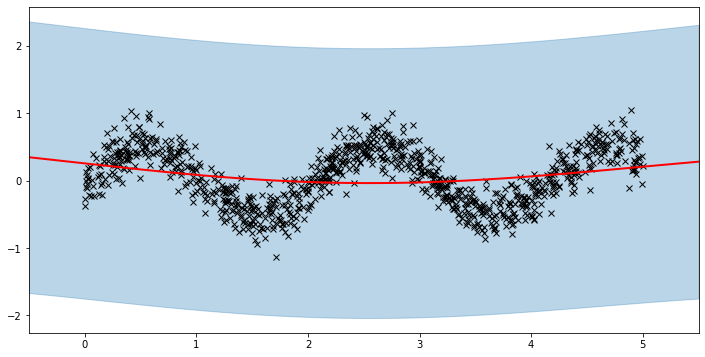

In [80]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chaosdonkey06/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

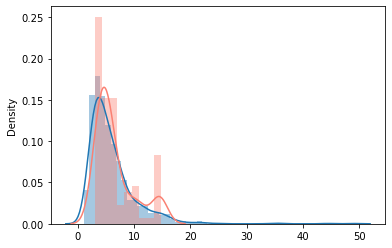

In [81]:
sns.distplot(x, label="Gamma")
sns.distplot(posterior_ls, label="Gamma", color='salmon')


# EpiEstim 

In [142]:
incidence = data.num_cases
incidence

date_time
2020-03-06      1.0
2020-03-07      0.0
2020-03-08      0.0
2020-03-09      0.0
2020-03-10      0.0
              ...  
2021-03-13    513.0
2021-03-14    575.0
2021-03-15    610.0
2021-03-16    662.0
2021-03-17    188.0
Freq: D, Name: num_cases, Length: 377, dtype: float64

In [156]:
def discrete_si_sample(x, mean_si=3.6, std_si=0.7):
    # Shift -1
    a = ((mean_si - 1) / std_si)**2  # shape
    b = std_si**2 / (mean_si - 1)    # scale

    # here concentration = shape, rate=1/scale
    generation_time   = dist.Gamma(concentration=a , rate=1/b )
    
    return generation_time.log_prob( x ), torch.exp(generation_time.log_prob(x))

def calc_time_windows(incidence, win_start=1, win_end=7):

    total_time = len(incidence)
    t_start    = np.arange(win_start, total_time-(win_end-win_start))
    t_end      = np.arange(win_end, total_time)

    nb_time_periods = len(t_start)

    return t_start, t_end, nb_time_periods

In [157]:
T = len(incidence)
real_dates = incidence.index

# Create our discretized serial interval distribution
si_distribution, log_si_distribution = discrete_si_sample(np.arange(1, T+1), mean_si=3.6, std_si=0.7)
t_start, t_end, nb_time_periods      = calc_time_windows(incidence, win_start=1, win_end=7)


# Calculate the parameters of our Rt gamma prior based on the provided mean and std of the serial interval
a_prior = (mean_prior / std_prior)**2
b_prior = std_prior**2 / mean_prior